## Imports

In [572]:
import numpy as np
from numpy import ndarray

In [573]:
from typing import Dict, List, Tuple

In [574]:
import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')
%matplotlib inline

from copy import deepcopy
from collections import deque

In [575]:
from lincoln.np_utils import assert_same_shape
from scipy.special import logsumexp

## Activations

In [576]:
def sigmoid(x: ndarray):
    return 1 / (1 + np.exp(-x))


def dsigmoid(y: ndarray):
    return sigmoid(y) * (1 - sigmoid(y))


def tanh(x: ndarray):
    return np.tanh(x)


def dtanh(y: ndarray):
    return 1 - np.tanh(y) * np.tanh(y)


def softmax(x, axis=None):
    return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


def batch_softmax(input_array: ndarray):
    out = []
    for row in input_array:
        out.append(softmax(row, axis=1))
    return np.stack(out)
    

## Lincoln code

### Optimizer

In [577]:
class RNNOptimizer(object):
    def __init__(self,
                 lr: float = 0.01,
                 gradient_clipping: bool = True) -> None:
        self.lr = lr
        self.gradient_clipping = gradient_clipping
        self.first = True

    def step(self) -> None:

        for layer in self.model.layers:
            for key in layer.params.keys():

                if self.gradient_clipping:
                    np.clip(layer.params[key]['deriv'], -2, 2, layer.params[key]['deriv'])

                self._update_rule(param=layer.params[key]['value'],
                                  grad=layer.params[key]['deriv'])

    def _update_rule(self, **kwargs) -> None:
        raise NotImplementedError()


In [578]:
class SGD(RNNOptimizer):
    def __init__(self,
                 lr: float = 0.01,
                 gradient_clipping: bool = True) -> None:
        super().__init__(lr, gradient_clipping)

    def _update_rule(self, **kwargs) -> None:

        update = self.lr*kwargs['grad']
        kwargs['param'] -= update
        

In [579]:
class AdaGrad(RNNOptimizer):
    def __init__(self,
                 lr: float = 0.01,
                gradient_clipping: bool = True) -> None:
        super().__init__(lr, gradient_clipping)
        self.eps = 1e-7

    def step(self) -> None:
        if self.first:
            self.sum_squares = {}
            for i, layer in enumerate(self.model.layers):
                self.sum_squares[i] = {}
                for key in layer.params.keys():
                    self.sum_squares[i][key] = np.zeros_like(layer.params[key]['value'])
            
            self.first = False

        for i, layer in enumerate(self.model.layers):
            for key in layer.params.keys():
                
                if self.gradient_clipping:
                    np.clip(layer.params[key]['deriv'], -2, 2, layer.params[key]['deriv'])
                
                self._update_rule(param=layer.params[key]['value'],
                                  grad=layer.params[key]['deriv'],
                                  sum_square=self.sum_squares[i][key])

    def _update_rule(self, **kwargs) -> None:

            # Update running sum of squares
            kwargs['sum_square'] += (self.eps +
                                     np.power(kwargs['grad'], 2))

            # Scale learning rate by running sum of squareds=5
            lr = np.divide(self.lr, np.sqrt(kwargs['sum_square']))

            # Use this to update parameters
            kwargs['param'] -= lr * kwargs['grad']

### Loss

In [580]:
class Loss(object):

    def __init__(self):
        pass

    def forward(self,
                prediction: ndarray,
                target: ndarray) -> float:

        # batch size x num_classes
        assert_same_shape(prediction, target)

        self.prediction = prediction
        self.target = target

        self.output = self._output()

        return self.output
    
    def backward(self) -> ndarray:

        self.input_grad = self._input_grad()

        assert_same_shape(self.prediction, self.input_grad)

        return self.input_grad

    def _output(self) -> float:
        raise NotImplementedError()

    def _input_grad(self) -> ndarray:
        raise NotImplementedError()

        
class SoftmaxCrossEntropy(Loss):
    def __init__(self, eps: float=1e-9) -> None:
        super().__init__()
        self.eps = eps
        self.single_class = False

    def _output(self) -> float:

        out = []
        for row in self.prediction:
            out.append(softmax(row, axis=1))
        softmax_preds = np.stack(out)

        # clipping the softmax output to prevent numeric instability
        self.softmax_preds = np.clip(softmax_preds, self.eps, 1 - self.eps)

        # actual loss computation
        softmax_cross_entropy_loss = -1.0 * self.target * np.log(self.softmax_preds) - \
            (1.0 - self.target) * np.log(1 - self.softmax_preds)

        return np.sum(softmax_cross_entropy_loss)

    def _input_grad(self) -> np.ndarray:

        return self.softmax_preds - self.target

In [581]:
class RNNCell(object):

    def __init__(self):
        pass

    def forward(self,
                x_in: ndarray, 
                H_in: ndarray,
                params_dict: Dict[str, ndarray]):
        '''
        param x: numpy array of shape (batch_size, vocab_size)
        param H_prev: numpy array of shape (batch_size, hidden_size)
        return self.x_out: numpy array of shape (batch_size, vocab_size)
        return self.H: numpy array of shape (batch_size, hidden_size)
        '''
        self.X_in = x_in
        self.H_in = H_in
    
        self.Z = np.column_stack((x_in, H_in))
        
        self.H_int = np.dot(self.Z, params_dict['W_f']['value']) + params_dict['B_f']['value']
        
        self.H_out = tanh(self.H_int)

        self.X_out = np.dot(self.H_out, params_dict['W_v']['value']) + params_dict['B_v']['value']
        
        return self.X_out, self.H_out


    def backward(self, 
                 X_out_grad: ndarray, 
                 H_out_grad: ndarray,
                 params_dict: Dict[str, ndarray]) -> Tuple[ndarray]:
        '''
        param x_out_grad: numpy array of shape (batch_size, vocab_size)
        param h_out_grad: numpy array of shape (batch_size, hidden_size)
        param RNN_Params: RNN_Params object
        return x_in_grad: numpy array of shape (batch_size, vocab_size)
        return h_in_grad: numpy array of shape (batch_size, hidden_size)
        '''
        
        assert_same_shape(X_out_grad, self.X_out)
        assert_same_shape(H_out_grad, self.H_out)

        params_dict['B_v']['deriv'] += X_out_grad.sum(axis=0)
        params_dict['W_v']['deriv'] += np.dot(self.H_out.T, X_out_grad)
        
        dh = np.dot(X_out_grad, params_dict['W_v']['value'].T)
        dh += H_out_grad
        
        dH_int = dh * dtanh(self.H_int)
        
        params_dict['B_f']['deriv'] += dH_int.sum(axis=0)
        params_dict['W_f']['deriv'] += np.dot(self.Z.T, dH_int)     
        
        dz = np.dot(dH_int, params_dict['W_f']['value'].T)

        X_in_grad = dz[:, :self.X_in.shape[1]]
        H_in_grad = dz[:, self.X_in.shape[1]:]
        
        return X_in_grad, H_in_grad

In [628]:
class RNNLayer(object):

    def __init__(self,
                 hidden_size: int,
                 output_size: int,
                 weight_scale: float):
        '''
        param sequence_length: int - length of sequence being passed through the network
        param vocab_size: int - the number of characters in the vocabulary of which we are predicting the next
        character.
        param hidden_size: int - the number of "hidden neurons" in the LSTM_Layer of which this node is a part.
        param learning_rate: float - the learning rate
        '''
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weight_scale = weight_scale
        self.start_H = np.zeros((1, hidden_size))
        self.first = True


    def _init_params(self,
                     input_: ndarray):
        
        self.vocab_size = input_.shape[2]
        
        self.params = {}
        self.params['W_f'] = {}
        self.params['B_f'] = {}
        self.params['W_v'] = {}
        self.params['B_v'] = {}
        
        self.params['W_f']['value'] = np.random.normal(loc = 0.0,
                                                      scale=self.weight_scale,
                                                      size=(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_f']['value'] = np.random.normal(loc = 0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.hidden_size))
        self.params['W_v']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(self.hidden_size, self.output_size))
        self.params['B_v']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.output_size))    
        
        self.params['W_f']['deriv'] = np.zeros_like(self.params['W_f']['value'])
        self.params['B_f']['deriv'] = np.zeros_like(self.params['B_f']['value'])
        self.params['W_v']['deriv'] = np.zeros_like(self.params['W_v']['value'])
        self.params['B_v']['deriv'] = np.zeros_like(self.params['B_v']['value'])
        
        self.cells = [RNNCell() for x in range(input_.shape[1])]

    
    def _clear_gradients(self):
        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['deriv'])
        

    def forward(self, x_seq_in: ndarray):
        '''
        param x_seq_in: numpy array of shape (batch_size, sequence_length, vocab_size)
        return x_seq_out: numpy array of shape (batch_size, sequence_length, vocab_size)
        '''
        if self.first:
            self._init_params(x_seq_in)
            self.first=False
        
        batch_size = x_seq_in.shape[0]
        
        H_in = np.copy(self.start_H)
        
        H_in = np.repeat(H_in, batch_size, axis=0)

        sequence_length = x_seq_in.shape[1]
        
        x_seq_out = np.zeros((batch_size, sequence_length, self.output_size))
        
        for t in range(sequence_length):

            x_in = x_seq_in[:, t, :]
            
            y_out, H_in = self.cells[t].forward(x_in, H_in, self.params)
      
            x_seq_out[:, t, :] = y_out
    
        self.start_H = H_in.mean(axis=0, keepdims=True)
        
        return x_seq_out


    def backward(self, x_seq_out_grad: ndarray):
        '''
        param loss_grad: numpy array of shape (batch_size, sequence_length, vocab_size)
        return loss_grad_out: numpy array of shape (batch_size, sequence_length, vocab_size)
        '''
        batch_size = x_seq_out_grad.shape[0]
        
        h_in_grad = np.zeros((batch_size, self.hidden_size))
        
        num_chars = x_seq_out_grad.shape[1]
        
        x_seq_in_grad = np.zeros((batch_size, num_chars, self.vocab_size))
        
        for t in reversed(range(num_chars)):
            
            x_out_grad = x_seq_out_grad[:, t, :]

            grad_out, h_in_grad = \
                self.cells[t].backward(x_out_grad, h_in_grad, self.params)
        
            x_seq_in_grad[:, t, :] = grad_out
        
        return x_seq_in_grad

In [583]:
class RNNModel(object):
    '''
    The Model class that takes in inputs and targets and actually trains the network and calculates the loss.
    '''
    def __init__(self, 
                 layers: List[RNNLayer],
                 sequence_length: int, 
                 vocab_size: int, 
                 loss: Loss):
        '''
        param num_layers: int - the number of layers in the network
        param sequence_length: int - length of sequence being passed through the network
        param vocab_size: int - the number of characters in the vocabulary of which we are predicting the next
        character.
        param hidden_size: int - the number of "hidden neurons" in the each layer of the network.
        '''
        self.layers = layers
        self.vocab_size = vocab_size
        self.sequence_length = sequence_length
        self.loss = loss
        for layer in self.layers:
            setattr(layer, 'sequence_length', sequence_length)

        
    def forward(self, 
                x_batch: ndarray):
        '''
        param inputs: list of integers - a list of indices of characters being passed in as the 
        input sequence of the network.
        returns x_batch_in: numpy array of shape (batch_size, sequence_length, vocab_size)
        '''       
        
        for layer in self.layers:

            x_batch = layer.forward(x_batch)
                
        return x_batch
        
    def backward(self, 
                 loss_grad: ndarray):
        '''
        param loss_grad: numpy array with shape (batch_size, sequence_length, vocab_size)
        returns loss: float, representing mean squared error loss
        '''

        for layer in reversed(self.layers):

            loss_grad = layer.backward(loss_grad)
            
        return loss_grad
                
    def single_step(self, 
                    x_batch: ndarray, 
                    y_batch: ndarray):
        '''
        The step that does it all:
        1. Forward pass & softmax
        2. Compute loss and loss gradient
        3. Backward pass
        4. Update parameters
        param inputs: array of length sequence_length that represents the character indices of the inputs to
        the network
        param targets: array of length sequence_length that represents the character indices of the targets
        of the network 
        return loss
        '''  
        
        x_batch_out = self.forward(x_batch)
        
        loss = self.loss.forward(x_batch_out, y_batch)
        
        loss_grad = self.loss.backward()
        
        for layer in self.layers:
            layer._clear_gradients()
        
        self.backward(loss_grad)
        return loss

In [584]:
class RNNTrainer:
    '''
    Takes in a text file and a model, and starts generating characters.
    '''
    def __init__(self, 
                 text_file: str, 
                 model: RNNModel,
                 optim: RNNOptimizer,
                 batch_size: int = 32):
        self.data = open(text_file, 'r').read()
        self.model = model
        self.chars = list(set(self.data))
        self.vocab_size = len(self.chars)
        self.char_to_idx = {ch:i for i,ch in enumerate(self.chars)}
        self.idx_to_char = {i:ch for i,ch in enumerate(self.chars)}
        self.sequence_length = self.model.sequence_length
        self.batch_size = batch_size
        self.optim = optim
        setattr(self.optim, 'model', self.model)
    

    def _generate_inputs_targets(self, 
                                 start_pos: int):
        
        inputs_indices = np.zeros((self.batch_size, self.sequence_length), dtype=int)
        targets_indices = np.zeros((self.batch_size, self.sequence_length), dtype=int)
        
        for i in range(self.batch_size):
            
            inputs_indices[i, :] = np.array([self.char_to_idx[ch] 
                            for ch in self.data[start_pos + i: start_pos + self.sequence_length  + i]])
            targets_indices[i, :] = np.array([self.char_to_idx[ch] 
                         for ch in self.data[start_pos + 1 + i: start_pos + self.sequence_length + 1 + i]])

        return inputs_indices, targets_indices


    def _generate_one_hot_array(self, 
                                indices: ndarray):
        '''
        param indices: numpy array of shape (batch_size, sequence_length)
        return batch - numpy array of shape (batch_size, sequence_length, vocab_size)
        ''' 
        batch = []
        for seq in indices:
            
            one_hot_sequence = np.zeros((self.sequence_length, self.vocab_size))
            
            for i in range(self.sequence_length):
                one_hot_sequence[i, seq[i]] = 1.0

            batch.append(one_hot_sequence) 

        return np.stack(batch)


    def sample_output(self, 
                      input_char: int, 
                      sample_length: int):
        '''
        Generates a sample output using the current trained model, one character at a time.
        param input_char: int - index of the character to use to start generating a sequence
        param sample_length: int - the length of the sample output to generate
        return txt: string - a string of length sample_length representing the sample output
        '''
        indices = []
        
        sample_model = deepcopy(self.model)
        
        for i in range(sample_length):
            input_char_batch = np.zeros((1, 1, self.vocab_size))
            
            input_char_batch[0, 0, input_char] = 1.0
            
            x_batch_out = sample_model.forward(input_char_batch)
            
            x_softmax = batch_softmax(x_batch_out)
            
            input_char = np.random.choice(range(self.vocab_size), p=x_softmax.ravel())
            
            indices.append(input_char)
            
        txt = ''.join(self.idx_to_char[idx] for idx in indices)
        return txt

    def train(self, 
              num_iterations: int, 
              sample_every: int=100):
        '''
        Trains the "character generator" for a number of iterations. 
        Each "iteration" feeds a batch size of 1 through the neural network.
        Continues until num_iterations is reached. Displays sample text generated using the latest version.
        '''
        plot_iter = np.zeros((0))
        plot_loss = np.zeros((0))
        
        num_iter = 0
        start_pos = 0
        
        moving_average = deque(maxlen=100)
        while num_iter < num_iterations:
            
            if start_pos + self.sequence_length + self.batch_size + 1 > len(self.data):
                start_pos = 0
            
            ## Update the model
            inputs_indices, targets_indices = self._generate_inputs_targets(start_pos)

            inputs_batch, targets_batch = \
                self._generate_one_hot_array(inputs_indices), self._generate_one_hot_array(targets_indices)
            
            loss = self.model.single_step(inputs_batch, targets_batch)
            self.optim.step()
            
            moving_average.append(loss)
            ma_loss = np.mean(moving_average)
            
            start_pos += self.batch_size
            
            plot_iter = np.append(plot_iter, [num_iter])
            plot_loss = np.append(plot_loss, [ma_loss])
            
            if num_iter % 100 == 0:
                plt.plot(plot_iter, plot_loss)
                display.clear_output(wait=True)
                plt.show()
                
                sample_text = self.sample_output(self.char_to_idx[self.data[start_pos]], 
                                                 200)
                print(sample_text)

            num_iter += 1
            
            

In [585]:
layers = [RNNLayer(hidden_size=256, output_size=62)]
mod = RNNModel(layers=layers,
               vocab_size=62, sequence_length=10,
               loss=SoftmaxCrossEntropy())
optim = SGD(lr=0.001, gradient_clipping=True)
trainer = RNNTrainer('input.txt', mod, optim)
# trainer.train(10000, sample_every=100)

TODO:

* Different optimizers
* `LSTMLayer`
* `GRULayer`



With RNN cells, this gets stuck in a local max. Let's try `LSTMLayer`s.

In [586]:
class LSTMModel(object):
    '''
    The Model class that takes in inputs and targets and actually trains the network and calculates the loss.
    '''
    def __init__(self, 
                 layers: List[LSTMLayer],
                 sequence_length: int, 
                 vocab_size: int, 
                 hidden_size: int,
                 loss: Loss):
        '''
        param num_layers: int - the number of layers in the network
        param sequence_length: int - length of sequence being passed through the network
        param vocab_size: int - the number of characters in the vocabulary of which we are predicting the next
        character.
        param hidden_size: int - the number of "hidden neurons" in the each layer of the network.
        '''
        self.layers = layers
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.loss = loss
        for layer in self.layers:
            setattr(layer, 'sequence_length', sequence_length)

        
    def forward(self, 
                x_batch: ndarray):
        '''
        param inputs: list of integers - a list of indices of characters being passed in as the 
        input sequence of the network.
        returns x_batch_in: numpy array of shape (batch_size, sequence_length, vocab_size)
        '''       
        
        for layer in self.layers:

            x_batch = layer.forward(x_batch)
                
        return x_batch
        
    def backward(self, 
                 loss_grad: ndarray):
        '''
        param loss_grad: numpy array with shape (batch_size, sequence_length, vocab_size)
        returns loss: float, representing mean squared error loss
        '''

        for layer in reversed(self.layers):

            loss_grad = layer.backward(loss_grad)
            
        return loss_grad
                
    def single_step(self, 
                    x_batch: ndarray, 
                    y_batch: ndarray):
        '''
        The step that does it all:
        1. Forward pass & softmax
        2. Compute loss and loss gradient
        3. Backward pass
        4. Update parameters
        param inputs: array of length sequence_length that represents the character indices of the inputs to
        the network
        param targets: array of length sequence_length that represents the character indices of the targets
        of the network 
        return loss
        '''  
        
        x_batch_out = self.forward(x_batch)
        
        loss = self.loss.forward(x_batch_out, y_batch)
        
        loss_grad = self.loss.backward()
        
        for layer in self.layers:
            layer._clear_gradients()
        
        self.backward(loss_grad)
        return loss

In [607]:
class LSTMLayer:

    def __init__(self,
                 hidden_size: int,
                 output_size: int,
                 weight_scale: float):
        '''
        param sequence_length: int - length of sequence being passed through the network
        param vocab_size: int - the number of characters in the vocabulary of which we are predicting the next
        character.
        param hidden_size: int - the number of "hidden neurons" in the LSTM_Layer of which this node is a part.
        param learning_rate: float - the learning rate
        '''
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weight_scale = weight_scale
        self.start_H = np.zeros((1, hidden_size))
        self.start_C = np.zeros((1, hidden_size))        
        self.first = True

        
    def _init_params(self,
                     input_: ndarray):
        
        self.vocab_size = input_.shape[2]

        self.params = {}
        self.params['W_f'] = {}
        self.params['B_f'] = {}
        self.params['W_i'] = {}
        self.params['B_i'] = {}
        self.params['W_c'] = {}
        self.params['B_c'] = {}
        self.params['W_o'] = {}
        self.params['B_o'] = {}        
        self.params['W_v'] = {}
        self.params['B_v'] = {}
        
        self.params['W_f']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size =(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_f']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size=(1, self.hidden_size))
        self.params['W_i']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size=(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_i']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.hidden_size))
        self.params['W_c']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_c']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.hidden_size))
        self.params['W_o']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_o']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.hidden_size))       
        self.params['W_v']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(self.hidden_size, self.output_size))
        self.params['B_v']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.output_size))
        
        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['value'])
        
        self.cells = [LSTMNode() for x in range(input_.shape[1])]


    def _clear_gradients(self):
        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['deriv'])
                    
        
    def forward(self, x_seq_in: ndarray):
        '''
        param x_seq_in: numpy array of shape (batch_size, sequence_length, vocab_size)
        return x_seq_out: numpy array of shape (batch_size, sequence_length, vocab_size)
        '''
        if self.first:
            self._init_params(x_seq_in)
            self.first=False
        
        batch_size = x_seq_in.shape[0]
        
        H_in = np.copy(self.start_H)
        C_in = np.copy(self.start_C)
        
        H_in = np.repeat(H_in, batch_size, axis=0)
        C_in = np.repeat(C_in, batch_size, axis=0)        

        sequence_length = x_seq_in.shape[1]
        
        x_seq_out = np.zeros((batch_size, sequence_length, self.output_size))
        
        for t in range(sequence_length):

            x_in = x_seq_in[:, t, :]
            
            y_out, H_in, C_in = self.cells[t].forward(x_in, H_in, C_in, self.params)
      
            x_seq_out[:, t, :] = y_out
    
        self.start_H = H_in.mean(axis=0, keepdims=True)
        self.start_C = C_in.mean(axis=0, keepdims=True)        
        
        return x_seq_out


    def backward(self, x_seq_out_grad: ndarray):
        '''
        param loss_grad: numpy array of shape (batch_size, sequence_length, vocab_size)
        return loss_grad_out: numpy array of shape (batch_size, sequence_length, vocab_size)
        '''
        
        batch_size = x_seq_out_grad.shape[0]
        
        h_in_grad = np.zeros((batch_size, self.hidden_size))
        c_in_grad = np.zeros((batch_size, self.hidden_size))        
        
        num_chars = x_seq_out_grad.shape[1]
        
        x_seq_in_grad = np.zeros((batch_size, num_chars, self.vocab_size))
        
        for t in reversed(range(num_chars)):
            
            x_out_grad = x_seq_out_grad[:, t, :]

            grad_out, h_in_grad, c_in_grad = \
                self.cells[t].backward(x_out_grad, h_in_grad, c_in_grad, self.params)
        
            x_seq_in_grad[:, t, :] = grad_out
        
        return x_seq_in_grad

In [588]:
class LSTMNode:

    def __init__(self):
        '''
        param hidden_size: int - the number of "hidden neurons" in the LSTM_Layer of which this node is a part.
        param vocab_size: int - the number of characters in the vocabulary of which we are predicting the next
        character.
        '''
        pass
        
    def forward(self, 
                X_in: ndarray, 
                H_in: ndarray, 
                C_in: ndarray, 
                params_dict: Dict[str, ndarray]):
        '''
        param x: numpy array of shape (1, vocab_size)
        param H_prev: numpy array of shape (1, hidden_size)
        param C_prev: numpy array of shape (1, hidden_size)
        return self.x_out: numpy array of shape (1, vocab_size)
        return self.H: numpy array of shape (1, hidden_size)
        return self.C: numpy array of shape (1, hidden_size)
        '''
        self.X_in = X_in
        self.C_in = C_in

        self.Z = np.column_stack((X_in, H_in))
        
        self.f_int = np.dot(self.Z, params_dict['W_f']['value']) + params_dict['B_f']['value']
        self.f = sigmoid(self.f_int)
        
        self.i_int = np.dot(self.Z, params_dict['W_i']['value']) + params_dict['B_i']['value']
        self.i = sigmoid(self.i_int)
        self.C_bar_int = np.dot(self.Z, params_dict['W_c']['value']) + params_dict['B_c']['value']
        self.C_bar = tanh(self.C_bar_int)

        self.C_out = self.f * C_in + self.i * self.C_bar
        self.o_int = np.dot(self.Z, params_dict['W_o']['value']) + params_dict['B_o']['value']
        self.o = sigmoid(self.o_int)
        self.H_out = self.o * tanh(self.C_out)

        self.X_out = np.dot(self.H_out, params_dict['W_v']['value']) + params_dict['B_v']['value']
        
        return self.X_out, self.H_out, self.C_out 


    def backward(self, 
                 X_out_grad: ndarray, 
                 H_out_grad: ndarray, 
                 C_out_grad: ndarray, 
                 params_dict: Dict[str, ndarray]):
        '''
        param loss_grad: numpy array of shape (1, vocab_size)
        param dh_next: numpy array of shape (1, hidden_size)
        param dC_next: numpy array of shape (1, hidden_size)
        param LSTM_Params: LSTM_Params object
        return self.dx_prev: numpy array of shape (1, vocab_size)
        return self.dH_prev: numpy array of shape (1, hidden_size)
        return self.dC_prev: numpy array of shape (1, hidden_size)
        '''
        
        assert_same_shape(X_out_grad, self.X_out)
        assert_same_shape(H_out_grad, self.H_out)
        assert_same_shape(C_out_grad, self.C_out)

        params_dict['W_v']['deriv'] += np.dot(self.H_out.T, X_out_grad)
        params_dict['B_v']['deriv'] += X_out_grad.sum(axis=0)

        dh_out = np.dot(X_out_grad, params_dict['W_v']['value'].T)        
        dh_out += H_out_grad
                         
        do = dh_out * tanh(self.C_out)
        do_int = dsigmoid(self.o_int) * do
        params_dict['W_o']['deriv'] += np.dot(self.Z.T, do_int)
        params_dict['B_o']['deriv'] += do_int.sum(axis=0)

        dC_out = dh_out * self.o * dtanh(self.C_out)
        dC_out += C_out_grad
        dC_bar = dC_out * self.i
        dC_bar_int = dtanh(self.C_bar_int) * dC_bar
        params_dict['W_c']['deriv'] += np.dot(self.Z.T, dC_bar_int)
        params_dict['B_c']['deriv'] += dC_bar_int.sum(axis=0)

        di = dC_out * self.C_bar
        di_int = dsigmoid(self.i_int) * di
        params_dict['W_i']['deriv'] += np.dot(self.Z.T, di_int)
        params_dict['B_i']['deriv'] += di_int.sum(axis=0)

        df = dC_out * self.C_in
        df_int = dsigmoid(self.f_int) * df
        params_dict['W_f']['deriv'] += np.dot(self.Z.T, df_int)
        params_dict['B_f']['deriv'] += df_int.sum(axis=0)

        dz = (np.dot(df_int, params_dict['W_f']['value'].T)
             + np.dot(di_int, params_dict['W_i']['value'].T)
             + np.dot(dC_bar_int, params_dict['W_c']['value'].T)
             + np.dot(do_int, params_dict['W_o']['value'].T))
    
        dx_prev = dz[:, :self.X_in.shape[1]]
        dH_prev = dz[:, self.X_in.shape[1]:]
        dC_prev = self.f * dC_out

        return dx_prev, dH_prev, dC_prev

In [589]:
layers1 = [LSTMLayer(hidden_size=256, output_size=128),
          RNNLayer(hidden_size=256, output_size=62)]
layers2 = [RNNLayer(hidden_size=256, output_size=128),
           LSTMLayer(hidden_size=256, output_size=62)]
mod = RNNModel(layers=layers2,
               vocab_size=62, sequence_length=20,
               loss=SoftmaxCrossEntropy())
optim = SGD(lr=0.001, gradient_clipping=True)
trainer = RNNTrainer('input.txt', mod, optim)
# trainer.train(10000, sample_every=100)

In [637]:
class GRUNode(object):

    def __init__(self):
        '''
        param hidden_size: int - the number of "hidden neurons" in the LSTM_Layer of which this node is a part.
        param vocab_size: int - the number of characters in the vocabulary of which we are predicting the next
        character.
        '''
        pass
        
    def forward(self, 
                X_in: ndarray, 
                H_in: ndarray,
                params_dict: Dict[str, ndarray]):
        '''
        param x: numpy array of shape (1, vocab_size)
        param H_prev: numpy array of shape (1, hidden_size)
        param C_prev: numpy array of shape (1, hidden_size)
        return self.x_out: numpy array of shape (1, vocab_size)
        return self.H: numpy array of shape (1, hidden_size)
        return self.C: numpy array of shape (1, hidden_size)
        '''
        self.X_in = X_in
        self.H_in = H_in        
        
        # reset gate
        self.X_r = np.dot(X_in, params_dict['W_xr']['value'])
        self.H_r = np.dot(H_in, params_dict['W_hr']['value'])

        # update gate        
        self.X_u = np.dot(X_in, params_dict['W_xu']['value'])
        self.H_u = np.dot(H_in, params_dict['W_hu']['value'])        
        
        # gates   
        self.r_int = self.X_r + self.H_r + params_dict['B_r']['value']
        self.r = sigmoid(self.r_int)
        
        self.u_int = self.X_r + self.H_r + params_dict['B_u']['value']
        self.u = sigmoid(self.u_int)

        # new state        
        self.h_reset = self.r * H_in
        self.X_h = np.dot(X_in, params_dict['W_xh']['value'])
        self.H_h = np.dot(self.h_reset, params_dict['W_hh']['value']) 
        self.h_bar_int = self.X_h + self.H_h + params_dict['B_h']['value']
        self.h_bar = tanh(self.h_bar_int)        
        
        self.H_out = self.u * self.H_in + (1 - self.u) * self.h_bar

        self.X_out = np.dot(self.H_out, params_dict['W_v']['value']) + params_dict['B_v']['value']
        
        return self.X_out, self.H_out


    def backward(self, 
                 X_out_grad: ndarray, 
                 H_out_grad: ndarray, 
                 params_dict: Dict[str, ndarray]):
        
        params_dict['B_v']['deriv'] += X_out_grad.sum(axis=0)
        params_dict['W_v']['deriv'] += np.dot(self.H_out.T, X_out_grad)

        dh_out = np.dot(X_out_grad, params_dict['W_v']['value'].T)        
        dh_out += H_out_grad
                         
        du = self.H_in * H_out_grad - self.h_bar * H_out_grad 
        dh_bar = (1 - self.u) * H_out_grad
        
        dh_bar_int = dh_bar * dtanh(self.h_bar_int)
        params_dict['B_h']['deriv'] += dh_bar_int.sum(axis=0)
        params_dict['W_xh']['deriv'] += np.dot(self.X_in.T, dh_bar_int)
        
        dX_in = np.dot(dh_bar_int, params_dict['W_xh']['value'].T)
 
        params_dict['W_hh']['deriv'] += np.dot(self.h_reset.T, dh_bar_int)
        dh_reset = np.dot(dh_bar_int, params_dict['W_hh']['value'].T)   
        
        dr = dh_reset * self.H_in
        dH_in = dh_reset * self.r        
        
        # update branch
        du_int = dsigmoid(self.u_int) * du
        params_dict['B_u']['deriv'] += du_int.sum(axis=0)

        dX_in += np.dot(du_int, params_dict['W_xu']['value'].T)
        params_dict['W_xu']['deriv'] += np.dot(self.X_in.T, du_int)
        
        dH_in += np.dot(du_int, params_dict['W_hu']['value'].T)
        params_dict['W_hu']['deriv'] += np.dot(self.H_in.T, du_int)        

        # reset branch
        dr_int = dsigmoid(self.r_int) * dr
        params_dict['B_r']['deriv'] += dr_int.sum(axis=0)

        dX_in += np.dot(dr_int, params_dict['W_xr']['value'].T)
        params_dict['W_xr']['deriv'] += np.dot(self.X_in.T, dr_int)
        
        dH_in += np.dot(dr_int, params_dict['W_hr']['value'].T)
        params_dict['W_hr']['deriv'] += np.dot(self.H_in.T, dr_int)   
        
        return dX_in, dH_in

In [638]:
class GRULayer(object):

    def __init__(self,
                 hidden_size: int,
                 output_size: int,
                 weight_scale: float = 0.01):
        '''
        param sequence_length: int - length of sequence being passed through the network
        param vocab_size: int - the number of characters in the vocabulary of which we are predicting the next
        character.
        param hidden_size: int - the number of "hidden neurons" in the LSTM_Layer of which this node is a part.
        param learning_rate: float - the learning rate
        '''
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weight_scale = weight_scale
        self.start_H = np.zeros((1, hidden_size))       
        self.first = True

        
    def _init_params(self,
                     input_: ndarray):
        
        self.vocab_size = input_.shape[2]

        self.params = {}
        self.params['W_xr'] = {}
        self.params['W_hr'] = {}
        self.params['B_r'] = {}
        self.params['W_xu'] = {}
        self.params['W_hu'] = {}
        self.params['B_u'] = {}
        self.params['W_xh'] = {}
        self.params['W_hh'] = {}
        self.params['B_h'] = {}        
        self.params['W_v'] = {}
        self.params['B_v'] = {}
        
        self.params['W_xr']['value'] = np.random.normal(loc=0.0,
                                                        scale=self.weight_scale,
                                                        size=(self.vocab_size, self.hidden_size))
        self.params['W_hr']['value'] = np.random.normal(loc=0.0,
                                                        scale=self.weight_scale,
                                                        size=(self.hidden_size, self.hidden_size))        
        self.params['B_r']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size=(1, self.hidden_size))
        self.params['W_xu']['value'] = np.random.normal(loc=0.0,
                                                        scale=self.weight_scale,
                                                        size=(self.vocab_size, self.hidden_size))
        self.params['W_hu']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size=(self.hidden_size, self.hidden_size))
        self.params['B_u']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.hidden_size))
        self.params['W_xh']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size=(self.vocab_size, self.hidden_size))
        self.params['W_hh']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size=(self.hidden_size, self.hidden_size))
        self.params['B_h']['value'] = np.random.normal(loc=0.0,
                                                       scale=1.0,
                                                       size=(1, self.hidden_size))
        self.params['W_v']['value'] = np.random.normal(loc=0.0,
                                                       scale=1.0,
                                                       size=(self.hidden_size, self.output_size))
        self.params['B_v']['value'] = np.random.normal(loc=0.0,
                                                       scale=1.0,
                                                       size=(1, self.output_size))    
        
        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['value'])
        
        self.cells = [GRUNode() for x in range(input_.shape[1])]


    def _clear_gradients(self):
        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['deriv'])
                    
        
    def forward(self, x_seq_in: ndarray):
        '''
        param x_seq_in: numpy array of shape (batch_size, sequence_length, vocab_size)
        return x_seq_out: numpy array of shape (batch_size, sequence_length, vocab_size)
        '''
        if self.first:
            self._init_params(x_seq_in)
            self.first=False
        
        batch_size = x_seq_in.shape[0]
        
        H_in = np.copy(self.start_H)

        H_in = np.repeat(H_in, batch_size, axis=0)      

        sequence_length = x_seq_in.shape[1]
        
        x_seq_out = np.zeros((batch_size, sequence_length, self.output_size))
        
        for t in range(sequence_length):

            x_in = x_seq_in[:, t, :]
            
            y_out, H_in = self.cells[t].forward(x_in, H_in, self.params)
      
            x_seq_out[:, t, :] = y_out
    
        self.start_H = H_in.mean(axis=0, keepdims=True)     
        
        return x_seq_out


    def backward(self, x_seq_out_grad: ndarray):
        '''
        param loss_grad: numpy array of shape (batch_size, sequence_length, vocab_size)
        return loss_grad_out: numpy array of shape (batch_size, sequence_length, vocab_size)
        '''
        
        batch_size = x_seq_out_grad.shape[0]
        
        h_in_grad = np.zeros((batch_size, self.hidden_size))        
        
        num_chars = x_seq_out_grad.shape[1]
        
        x_seq_in_grad = np.zeros((batch_size, num_chars, self.vocab_size))
        
        for t in reversed(range(num_chars)):
            
            x_out_grad = x_seq_out_grad[:, t, :]

            grad_out, h_in_grad = \
                self.cells[t].backward(x_out_grad, h_in_grad, self.params)
        
            x_seq_in_grad[:, t, :] = grad_out
        
        return x_seq_in_grad

## Experiments

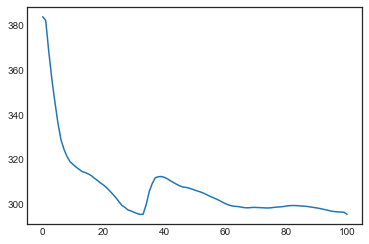

gbitheehbTnhBdhtt
hdgggd rgurtnmhdutnehhuh
utd
l'h nt oo s nihhvah wtGhhrweuwthta hl,thsehghtrlststtite
enn  etthhsgt hhsthtehr nhot h, t, n hhtggyd pdttghoeettt aache
n ahlgog t g,,thdhf thhf,htotgui


KeyboardInterrupt: 

In [629]:
layers1 = [LSTMLayer(hidden_size=256, output_size=62, weight_scale=0.01)]
mod = RNNModel(layers=layers1,
               vocab_size=62, sequence_length=25,
               loss=SoftmaxCrossEntropy())
optim = AdaGrad(lr=0.01, gradient_clipping=True)
trainer = RNNTrainer('input.txt', mod, optim, batch_size=3)
trainer.train(10000, sample_every=100)

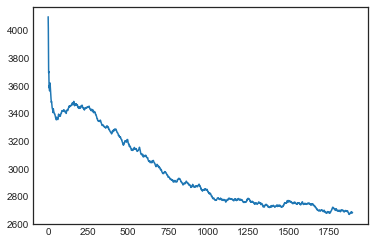

it Usived
aw herI?'OZ:
.h mr or is i srad ho chatesr .nT:
Wae hord, is ant bart thi threDlt hut ghas dor the lamas R : os thet iont a hat meo, whease rraooct lithiasitheuity ons, mincih'r-Kn
 TIRSoC L


In [630]:
layers2 = [RNNLayer(hidden_size=256, output_size=128, weight_scale=0.1),
           LSTMLayer(hidden_size=256, output_size=62, weight_scale=0.01)]
mod = RNNModel(layers=layers2,
               vocab_size=62, sequence_length=25,
               loss=SoftmaxCrossEntropy())
optim = AdaGrad(lr=0.01, gradient_clipping=True)
trainer = RNNTrainer('input.txt', mod, optim, batch_size=32)
trainer.train(2000, sample_every=100)

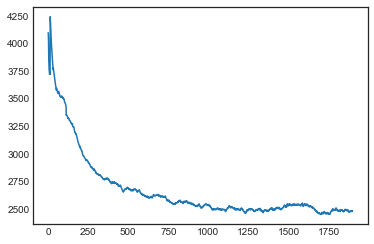

ill .

BZLINCEUXB:
Walrend, I Lad, be hores and ve hinw, triele,
And b
HewIES: I waculde tobey Band
I, breanced tagkeld xe a l be say qaus
I ttrou noand in juinhndrbeamt be.
Bh fure rore I not weall z


In [616]:
layers2 = [LSTMLayer(hidden_size=256, output_size=128, weight_scale=0.1),
           LSTMLayer(hidden_size=256, output_size=62, weight_scale=0.01)]
mod = RNNModel(layers=layers2,
               vocab_size=62, sequence_length=25,
               loss=SoftmaxCrossEntropy())
optim = SGD(lr=0.01, gradient_clipping=True)
trainer = RNNTrainer('input.txt', mod, optim, batch_size=32)
trainer.train(2000, sample_every=100)

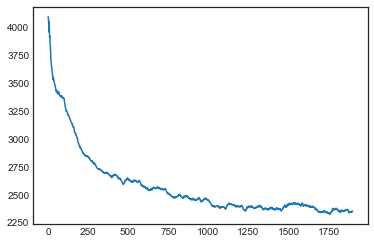

ils at lase'J'ally leathe hou shade thingld a buthans. I a kily ealy?

QSROLET:
Call sparut:
Seen grimter: fee'ilg  fromi'd doied bestree, ds Mt vand-ad not thoughtly:
And my and artive miey.

PqIBEHI


In [623]:
layers2 = [LSTMLayer(hidden_size=256, output_size=62, weight_scale=0.01)]
mod = RNNModel(layers=layers2,
               vocab_size=62, sequence_length=25,
               loss=SoftmaxCrossEntropy())
optim = SGD(lr=0.01, gradient_clipping=True)
trainer = RNNTrainer('input.txt', mod, optim, batch_size=32)
trainer.train(2000, sample_every=100)

In [627]:
layers2 = [
    RNNLayer(hidden_size=256, output_size=62, weight_scale=0.01),
    LSTMLayer(hidden_size=256, output_size=62, weight_scale=0.01)]
mod = RNNModel(layers=layers2,
               vocab_size=62, sequence_length=25,
               loss=SoftmaxCrossEntropy())
optim = SGD(lr=0.01, gradient_clipping=True)
trainer = RNNTrainer('input.txt', mod, optim, batch_size=32)
trainer.train(2000, sample_every=100)

TypeError: randn() got an unexpected keyword argument 'size'

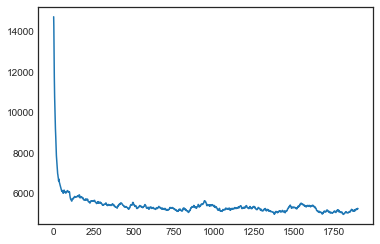

 es  and at aane ss are annee am uan nd,a es ase aerua, aee, aness I ar us ses es,, as, e manes  anne anasam,e anan me anI ee, Iease, aand sn sane es ahe ne, har eas le, anens he ar me we rmhe end me 


In [639]:
layers2 = [GRULayer(hidden_size=256, output_size=62, weight_scale=0.1)]
mod = RNNModel(layers=layers2,
               vocab_size=62, sequence_length=25,
               loss=SoftmaxCrossEntropy())
optim = SGD(lr=0.01, gradient_clipping=True)
trainer = RNNTrainer('input.txt', mod, optim, batch_size=32)
trainer.train(2000, sample_every=100)

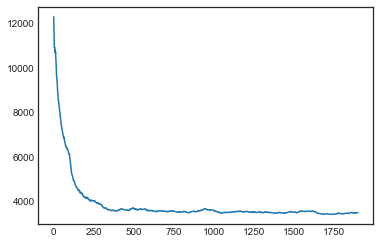

fafrn t saen handroyew
 la .uiul a aeEaea shdeia
u,e,
HsmsHne hdtae tapu fhelttuchpt  d -eNthtum,d emo,luvoshis.e esm  hosf'uom,d iecisa saee,otgvHlpsiiolyeiun Ipe,yrIBEoewosAtLool e ae aaEa
iEoWl afs


In [641]:
layers2 = [GRULayer(hidden_size=256, output_size=62, weight_scale=0.1)]
mod = RNNModel(layers=layers2,
               vocab_size=62, sequence_length=25,
               loss=SoftmaxCrossEntropy())
optim = AdaGrad(lr=0.01, gradient_clipping=False)
trainer = RNNTrainer('input.txt', mod, optim, batch_size=32)
trainer.train(2000, sample_every=100)

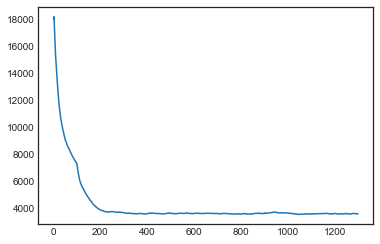

nertf wrtef fn ieu n
e asgea  tea e euhrlol aamynr  f bndrrnfh nshu hh j otelocestlidiritetio n fan
, ,awesehymnmmurnl
yho a iae semnasehweostte:lawtshh  esnle iol
a
io to piBrfiotw
 blaom  lmdtarusId


KeyboardInterrupt: 

In [621]:
layers2 = [GRULayer(hidden_size=256, output_size=62, weight_scale=0.1)]
mod = RNNModel(layers=layers2,
               vocab_size=62, sequence_length=25,
               loss=SoftmaxCrossEntropy())
optim = AdaGrad(lr=0.01, gradient_clipping=True)
trainer = RNNTrainer('input.txt', mod, optim, batch_size=32)
trainer.train(2000, sample_every=100)

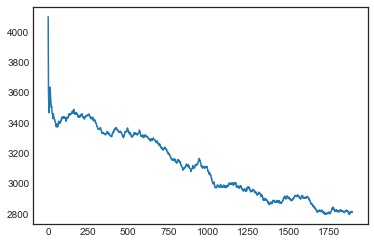

it seQ nat: Heow
rhthe arast or wand lu aroren towweeacp oalss
garde wncd anUg oncsnkin
;S
RAAno iudoe har Bes hBthae afr yy yordapol: tou 
itiests
ire:
wwie
BwlO oey har. Pous and coitus oulep rasale


In [613]:
layers2 = [GRULayer(hidden_size=256, output_size=128, weight_scale=0.1),
           LSTMLayer(hidden_size=256, output_size=62, weight_scale=0.01)]
mod = RNNModel(layers=layers2,
               vocab_size=62, sequence_length=25,
               loss=SoftmaxCrossEntropy())
optim = AdaGrad(lr=0.01, gradient_clipping=True)
trainer = RNNTrainer('input.txt', mod, optim, batch_size=32)
trainer.train(2000, sample_every=100)

```python
        inputs_indices = np.zeros((self.batch_size, self.sequence_length), dtype=int)
        targets_indices = np.zeros((self.batch_size, self.sequence_length), dtype=int)
        
        for i in range(self.batch_size):
            
            inputs_indices[i, :] = np.array([self.char_to_idx[ch] 
                            for ch in self.data[start_pos + i: start_pos + self.sequence_length  + i]])
            targets_indices[i, :] = np.array([self.char_to_idx[ch] 
                         for ch in self.data[start_pos + 1 + i: start_pos + self.sequence_length + 1 + i]])
        import pdb; pdb.set_trace()
        return inputs_indices, targets_indices
```    

```python
        params_dict['B_v']['deriv'] += X_out_grad.sum(axis=0)
        params_dict['W_v']['deriv'] += np.dot(self.H_out.T, X_out_grad)

        dh_out = np.dot(X_out_grad, params_dict['W_v']['value'].T)        
        dh_out += H_out_grad
                         
        du = self.H_in * H_out_grad - self.H_in * H_out_grad 
        dh_bar = (1 - self.u) * H_out_grad
        
        dh_bar_int = dh_bar * dtanh(self.h_bar_int)
        params_dict['B_h']['deriv'] += dh_bar_int.sum(axis=0)
        params_dict['W_xh']['deriv'] = np.dot(self.X_in.T, dh_bar_int)
        
        dX_in = np.dot(dh_bar_int, params_dict['W_xh']['value'].T)
```